## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from nltk.corpus import stopwords
from random import choice
from string import punctuation

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Prepare English dictionary for language detection

In [3]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [4]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [5]:
pd.set_option("max_colwidth", 280)

In [6]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files

In [7]:
subtweets_data = [t for t in json.load(open("../data/other_data/subtweets.json")) 
                  if t["tweet_data"]["user"]["lang"] == "en" 
                  and t["reply"]["user"]["lang"] == "en"]

In [8]:
non_subtweets_data = [t for t in json.load(open("../data/other_data/non_subtweets.json")) 
                      if t["tweet_data"]["user"]["lang"] == "en" 
                      and t["reply"]["user"]["lang"] == "en"]

#### Only use tweets with at least 2 English words

In [9]:
%%time
subtweets_data = [t["tweet_data"]["full_text"] 
                  for t in subtweets_data 
                  if sum([english_dict.check(token) 
                          for token in tokenizer.tokenize(t["tweet_data"]["full_text"])]) >= 2]

CPU times: user 4.38 s, sys: 1.67 s, total: 6.05 s
Wall time: 6.87 s


In [10]:
%%time
non_subtweets_data = [t["tweet_data"]["full_text"] 
                      for t in non_subtweets_data 
                      if sum([english_dict.check(token) 
                              for token in tokenizer.tokenize(t["tweet_data"]["full_text"])]) >= 2]

CPU times: user 6.79 s, sys: 2.55 s, total: 9.34 s
Wall time: 10 s


#### Show examples

In [11]:
print("Subtweets dataset example:")
print(choice(subtweets_data))

Subtweets dataset example:
And camp invites is not offers https://t.co/FeQwRQIJVH


In [12]:
print("Non-subtweets dataset example:")
print(choice(non_subtweets_data))

Non-subtweets dataset example:
Lmao this is disrespectful to Daniel Caesar https://t.co/gfbCFTQtEC


#### Find the length of the smaller dataset

In [13]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [14]:
subtweets_data = subtweets_data[:smallest_length]

In [15]:
non_subtweets_data = non_subtweets_data[:smallest_length]

In [16]:
print("Smallest dataset length: {}".format(len(non_subtweets_data)))

Smallest dataset length: 8006


#### Prepare data for training

In [17]:
subtweets_data = [(tweet.replace("\u2018", "'").replace("\u2019", "'").replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                   "subtweet") for tweet in subtweets_data]

In [18]:
non_subtweets_data = [(tweet.replace("\u2018", "'").replace("\u2019", "'").replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<"), 
                       "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [19]:
training_data = subtweets_data + non_subtweets_data

#### Class for distinguishing polarizing parts of speech as features

In [20]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        others = ["You", "You're", "Youre", "Your", "Yours", "U", "Ur", "Urs",
                  "She", "She's", "Shes", "Her", "Hers", 
                  "He", "He's", "Hes", "Him", "His", 
                  "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        others_lower = set([other.lower() for other in others])
        
        selfs = ["I", "I'm", "Im", "We", "We're", "Our", "Ours", "My", "Mine", "Us"]
        selfs_lower = set([self.lower() for self in selfs])
        
        names_lower = set([name.lower() for name in open("../data/other_data/first_names.txt").read().split("\n")])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
                
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_others = len(others_lower.intersection(tokenized_text))
            num_selfs = len(selfs_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            num_names = len(names_lower.intersection(tokenized_text))
            
            weighted_dict = {"num_others": num_others,
                             "num_selfs": num_selfs,
                             "num_at_symbols": num_at_symbols,
                             "num_subtweet": num_subtweet,
                             "num_urls": num_urls, 
                             "num_names": num_names}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [21]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                         ngram_range=(1, 3), 
                                         stop_words="english")),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [22]:
text_training_data = np.array([row[0] for row in training_data])

In [23]:
class_training_data = np.array([row[1] for row in training_data])

In [24]:
kf = KFold(n_splits=10, random_state=7, shuffle=True)

In [25]:
%%time
cnf_matrix = np.zeros((2, 2), dtype=int)
for train_index, test_index in kf.split(text_training_data):
    # print("TRAIN:", train_index, "TEST:", test_index)
    
    text_train, text_test = text_training_data[train_index], text_training_data[test_index]
    class_train, class_test = class_training_data[train_index], class_training_data[test_index]
    
    sentiment_pipeline.fit(text_train, class_train)
    predictions = sentiment_pipeline.predict(text_test)
    
    # print(predictions)
    
    cnf_matrix += confusion_matrix(class_test, predictions)
    
    print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

non-subtweet       0.71      0.79      0.75       803
    subtweet       0.76      0.68      0.72       799

 avg / total       0.74      0.74      0.73      1602

              precision    recall  f1-score   support

non-subtweet       0.72      0.76      0.74       820
    subtweet       0.73      0.70      0.72       782

 avg / total       0.73      0.73      0.73      1602

              precision    recall  f1-score   support

non-subtweet       0.73      0.78      0.75       815
    subtweet       0.76      0.69      0.72       786

 avg / total       0.74      0.74      0.74      1601

              precision    recall  f1-score   support

non-subtweet       0.70      0.79      0.75       776
    subtweet       0.78      0.69      0.73       825

 avg / total       0.74      0.74      0.74      1601

              precision    recall  f1-score   support

non-subtweet       0.72      0.77      0.75       806
    subtweet   

#### Define function for visualizing confusion matrices

In [26]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted Label")

#### Show the matrices

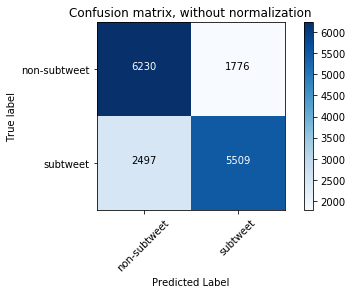

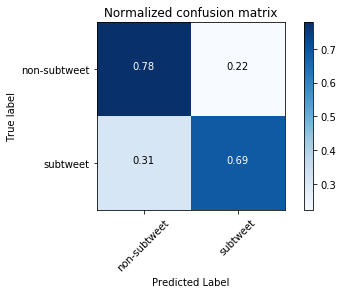

In [27]:
class_names = ["non-subtweet", "subtweet"]

# cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Update matplotlib style

In [28]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [29]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [30]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [31]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [32]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [33]:
tests_dataframe(test_tweets_df, text_column="Tweet", 
                sentiment_column="Sentiment").drop(["sentiment_score", 
                                                    "subtweet_negative_probability"], axis=1).head()

,subtweet_positive_probability,tweet
1,0.8904,Isn't it funny how some people don't know their place?
0,0.8819,Some people don't know their place.
2,0.8272,How come you people act like this?
3,0.7649,You're such a nerd.
4,0.6427,"I love Noah, he's so cool."


#### Tests on friends' tweets

#### Aaron

In [34]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [35]:
aaron_df = tests_dataframe(aaron_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [36]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [37]:
aaron_df.head()

,subtweet_positive_probability,tweet
2137,0.9769,Also you don't need to resort to social media 24/7 to complain about your very privileged life ¯\_(ツ)_/¯
2073,0.9557,"""i do have aids ¯\_(ツ)_/¯. That's what happens when you're super gay"" #quotesfromwork"
2151,0.9518,When I try to be supportive and caring I get ignored and then I'm told I'm not being supportive or caring ¯\_(ツ)_/¯
2079,0.9512,When you get called a faggot ¯\_(ツ)_/¯
1596,0.9375,¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol ¯\_(ツ)_/¯ lol


In [38]:
aaron_df_for_plotting = aaron_df.drop(["tweet"], axis=1)

#### Julia

In [39]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [40]:
julia_df = tests_dataframe(julia_df, text_column="Text", 
                           sentiment_column="Sentiment").drop(["sentiment_score", 
                                                               "subtweet_negative_probability"], axis=1)

In [41]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [42]:
julia_df.head()

,subtweet_positive_probability,tweet
3613,0.9223,don't follow bachelor contestants u liked on insta bc it will just make u hate them for being annoying and unoriginal #sorrycaila
3913,0.9198,tfw ur anxiety kills ur appetite but you can't do anything done bc ur still hungry so u just get more anxiety #gr8
2936,0.9143,how do you tell ur coach who probably hates ur forgetful ass at this point that you can't go to practice bc u stayed up all night lmk
2970,0.9114,"funny how some people have suddenly become serious """"academics"""" and think they're amazingly intelligent now....try no bitch u fake as fuck"
2776,0.9095,"if you continually cross post content on various social media to get validation that you're funny, you, regrettably, are probably not funny"


In [43]:
julia_df_for_plotting = julia_df.drop(["tweet"], axis=1)

#### Lex

In [44]:
lex_df = pd.read_csv("../data/data_for_testing/friends_data/gothodile_tweets.csv").dropna()
lex_df["Sentiment"] = None

In [45]:
lex_df = tests_dataframe(lex_df, text_column="Text", 
                         sentiment_column="Sentiment").drop(["sentiment_score",
                                                             "subtweet_negative_probability"], axis=1)

In [46]:
lex_df.to_csv("../data/data_from_testing/friends_data/gothodile_tests.csv")

In [47]:
lex_df.head()

,subtweet_positive_probability,tweet
661,0.9424,dudes have zero concept of girls being out of their league. i feel like 98% of dudes out there realistically think that if they met Megan Fox that she would want to sleep with them. thats the level of unreality we're dealing with.
357,0.9386,"""im like the girl that you take out because she seems nice but then your first time having sex I growl and bite your nipple and you tell all your friends about how weird it was"""
662,0.9308,"i hate ugly dudes trashing girls that are so out of their league its a joke.... like sure you can be like ""well margot robbie's basically flat chested if u actually look at her"" like.. you have cum stained sweat pants and dorito dust on your chin, you little worm"
2110,0.9144,needing help on things but not wanting to ask because u know theyre just gonna say some stupid shit and u dont want to go to jail for murder
3052,0.9125,"but like if you tell people you're a psych major they're like ""o haha soft science"""


In [48]:
lex_df_for_plotting = lex_df.drop(["tweet"], axis=1)

#### Noah

In [49]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [50]:
noah_df = tests_dataframe(noah_df, text_column="Text", 
                          sentiment_column="Sentiment").drop(["sentiment_score", 
                                                              "subtweet_negative_probability"], axis=1)

In [51]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [52]:
noah_df.head()

,subtweet_positive_probability,tweet
2022,0.9280,you may think you're cool but unless you're friends with my friends you're not actually as cool as you could be
2027,0.9220,IF U CALL URSELF A WEEB BUT DONT HAVE ANIME PROF PICS ON ALL SOCIAL MEDIA\n DELETE UR ACCOUNTS
1716,0.9085,If you don't make your meatloaf with ketchup don't bother talking to me
2588,0.9075,"I'm gonna start a political party that exists only to express its members indecisiveness. It will be the ""¯\_(ツ)_/¯"" party."
2367,0.9050,TFW you forget you're logged in to your twitter bot and you accidentally Tweet from it


In [53]:
noah_df_for_plotting = noah_df.drop(["tweet"], axis=1)

#### Rename the columns for later

In [54]:
aaron_df_for_plotting_together = aaron_df_for_plotting.rename(columns={"subtweet_positive_probability": "Aaron"})

In [55]:
julia_df_for_plotting_together = julia_df_for_plotting.rename(columns={"subtweet_positive_probability": "Julia"})

In [56]:
lex_df_for_plotting_together = lex_df_for_plotting.rename(columns={"subtweet_positive_probability": "Lex"})

In [57]:
noah_df_for_plotting_together = noah_df_for_plotting.rename(columns={"subtweet_positive_probability": "Noah"})

#### Prepare statistics on friends' tweets

In [58]:
friends_df = pd.concat([aaron_df_for_plotting_together, 
                        julia_df_for_plotting_together, 
                        lex_df_for_plotting_together, 
                        noah_df_for_plotting_together], ignore_index=True)

In [59]:
friends_df.describe()

,Aaron,Julia,Lex,Noah
count,2640.0000,4356.0000,3488.0000,2814.0000
mean,0.4774,0.5046,0.5247,0.4809
std,0.1925,0.1523,0.1698,0.1722
min,0.0005,0.0024,0.0007,0.0011
25%,0.3378,0.4075,0.4357,0.3605
50%,0.5036,0.5080,0.5336,0.4992
75%,0.6159,0.6083,0.6434,0.5990
max,0.9769,0.9223,0.9424,0.9280


In [60]:
aaron_mean = friends_df.describe().Aaron[1]
aaron_std = friends_df.describe().Aaron[2]

julia_mean = friends_df.describe().Julia[1]
julia_std = friends_df.describe().Julia[2]

noah_mean = friends_df.describe().Noah[1]
noah_std = friends_df.describe().Noah[2]

lex_mean = friends_df.describe().Lex[1]
lex_std = friends_df.describe().Lex[2]

#### Plot all the histograms

/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


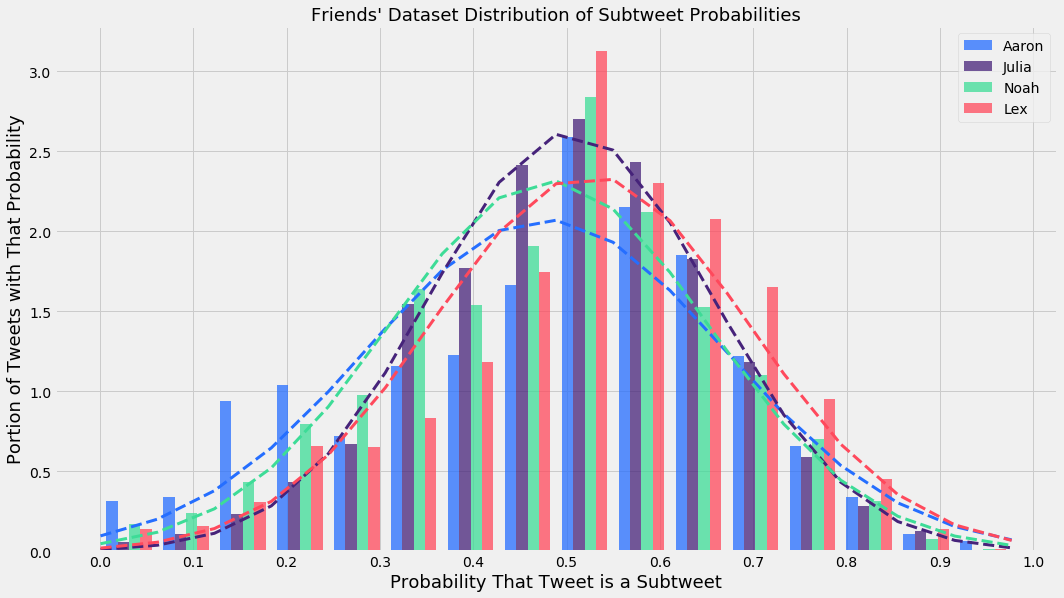

CPU times: user 761 ms, sys: 49.9 ms, total: 811 ms
Wall time: 1.06 s


In [61]:
%%time
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist([aaron_df_for_plotting.subtweet_positive_probability, 
                            julia_df_for_plotting.subtweet_positive_probability, 
                            noah_df_for_plotting.subtweet_positive_probability, 
                            lex_df_for_plotting.subtweet_positive_probability], 
                           bins="doane",
                           color=["#256EFF", "#46237A", "#3DDC97", "#FF495C"],
                           density=True, label=["Aaron", "Julia", "Noah", "Lex"], 
                           alpha=0.75)

aaron_line = scipy.stats.norm.pdf(bins, aaron_mean, aaron_std)
ax.plot(bins, aaron_line, "--", color="#256EFF", linewidth=3)

julia_line = scipy.stats.norm.pdf(bins, julia_mean, julia_std)
ax.plot(bins, julia_line, "--", color="#46237A", linewidth=3)

noah_line = scipy.stats.norm.pdf(bins, noah_mean, noah_std)
ax.plot(bins, noah_line, "--", color="#3DDC97", linewidth=3)

lex_line = scipy.stats.norm.pdf(bins, lex_mean, lex_std)
ax.plot(bins, lex_line, "--", color="#FF495C", linewidth=3)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Friends' Dataset Distribution of Subtweet Probabilities", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Portion of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [62]:
training_data = [" ".join([token for token in tokenizer.tokenize(pair[0]) if "@" not in token]) 
                 for pair in training_data]

#### Lengths (Less than or equal to 280 characters and greater than or equal to 5 characters)

In [63]:
length_data = [len(tweet) for tweet in training_data]

In [64]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [65]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [66]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [67]:
length_data = length_data_for_stats.Length.tolist()

In [68]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
14987,325,"from 10/18 / 15 when he 1st played hurt & began noticeably throwing w poor mechanics thru end of his injured 2016 yr , luck's stats were as good as his healthiest / best 2013-2014 yrs : - injured : 61 % comp , 7.4 ypa , 93 rtg , 41:18 td : int - healthy : 61 % comp , 7.2 ypa ..."
15954,321,""" it is a key agreement that shapes today's globalisation "" - frau merkel on the paris ' agreement ' . climatefraud-a contrived tool of the deadly eu / un-centric marxist-globalist / islamist alliance , to wealth transfer & to create such energy poverty , that sovereignwester..."
15411,321,"pentagon : master sergeant jonathan j . dunbar , assigned to headquarters , u . s . army special operations command , fort bragg , n . c . , was kia mar . 30 , while deployed in support of operation inherent resolve . dunbar died from wounds received during combat operations ..."
8934,320,i've fallen into a rabbit hole of goals from that 2016 run . faves : 1 ) crosby's goal against raanta in rd . 1 . 2 ) cullen's goal in ny . third period . tie game . 3 ) fehr's goal in game 2 vs . washington . 4 ) rust's breakaway in game 6 vs . tampa . 5 ) fehr's game 5 insu...
13602,320,"you are a neutral political analyst :) :) stick to defending the congress and its inept bunch .. as for what is a ' perforation ' , i trust the cmo more than quacks like #kafeelkhan or that sundry bunch of ' neutral analysts ' , who know zilch , but have an opinion on everyth..."


In [69]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
3432,5,hi ho
1560,5,s a d
3250,5,bye .
5106,6,nice .
4839,6,miss u


In [70]:
length_data_for_stats.describe()

,Length
count,16012.0000
mean,118.1940
std,76.4052
min,5.0000
25%,58.0000
50%,97.0000
75%,162.0000
max,325.0000


#### Punctuation

In [71]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [72]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

In [73]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
7192,13,"if u were killed tomorrow , i wouldnt go 2 ur funeral cuz id b n jail 4 killin da person that killed u ! ... ___ ... / _ = = o ; ; ; ___ [ ] ... ) , — - . ( _ ( __ ) / ... / / ( .. ) ) , — - - "" ... / / ___ / / .. / / ___ / / we true homies we ride together we die together"
13680,11,"[ new ] in response to mondli makhanya's column on #winniemandela - in a world that ( still ) tells women to be humble and kowtow to respectability , mam ' winnie is someone we aspire to be like . https://t.co/T5GBAiHswR"
14220,11,""" hey mister , she's my sister ! "" happy #nationalsiblingsday ! is in rochester may 1-6 ( only 3 weeks away ) for 8 performances ! for more info and how to buy tickets , visit https://t.co/4PSY94m0Bi . https://t.co/lCI1rw6phq"
11645,11,"[ bang dream girls band party seiyuu profiles arpil 2018 edition ] order of posting : - hello , happy world ( 4/8 ) - roselia ( 4/8 ) - pastel * palettes ( 4/9 ) - afterglow ( 4/9 ) - poppin'party ( 4/10 ) let's go !"
1703,10,""" i really can't stand the young ' turds ' ( ) and especially the guy who runs the place . his name is like cank or something like that , like a canker sore , . i can't even pronounce his last name . "" - #westand https://t.co/92eA3ndbVh"


In [74]:
punctuation_data_for_stats.describe()

,Punctuation
count,16012.0000
mean,2.8888
std,1.9488
min,0.0000
25%,1.0000
50%,3.0000
75%,4.0000
max,13.0000


#### Stop words

In [75]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [76]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

In [77]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,"i don't yet have adequate words to do so , but someday i wanna write about the beautiful dance which happens in google docs between a writer & a good editor working simultaneously towards a deadline . when it's working , it's a beautiful dance — though no one really sees it ."
8406,8,"still important : jw uncovered evidence showing that lois lerner was actively involved in a lengthy cover-up of improper irs activities , targeting , & abuses . jw further revealed the irs scandal included the involvement of obama's doj & the fbi as well . https://t.co/J0UKwp..."
8311,8,"at #aaem18 : advocate for yourself so that you can advocate for your pts . tx then like we know them , bc their problems are our problems"
8312,8,"wrong decision . we women don't need any #reservation anywhere , be it in the parliament or the iits . gender based reservation is against the very principle of gender equality . https://t.co/vEJZp0WAHC"
8313,8,i just a quad espresso ... pray for my soul .


In [78]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
2365,0,.. . - .. - - - ... - . . - - - . - - . - .. . -
10042,0,훠이니 ... / 괴롭다 ...
13363,1,l o l 👋 🏽 👋 🏽
15595,1,who up ?
3250,1,bye .


In [79]:
stop_words_data_for_stats.describe()

,Stop words
count,16012.0000
mean,7.3168
std,1.0624
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words (at least 2)

In [80]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [81]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [82]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [83]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

In [84]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
14562,"give away ! the rules are really easy , all you have to do is : 1 . must be following me ( i check ) 2 . rt and fav this tweet 3 . tag your mutuals / anyone 4 . only 1 winner ! 5 . i ship worldwide ;) it ends in 8th may 2018 or when this tweet hit 2k rt and like ! good luck !...",60
13916,"- many 👮 ‍ ♂ ️ suffer in silence , not always by choice but by design ! #ptsd can be a career killer & worse many pd's do not see p . t . s . d as an insured disability ; this has to change 🆘 - hiding mine for 3 years made my #fight unbearable ! please help us #unmaskptsd & #...",59
7159,"crazy how wrong u can be about someone . a girl i graduated w / was always doing drugs & got pregnant at 16 . i assumed she'd end up being a loser but it turn out she now has 4 beautiful kids & is making over $ 4,500 / month just off of child support payments from the 3 diffe...",57
4978,"got into a tepid back nd forth w / a uknowwhoaj + columnist bc i said they steal their "" hot takes "" from blk twitter & alike . wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is post colonial memes for oriental...",57
11978,"thought i'd bring this back ... #tuesdaythoughts and no , i'm not talking about myself here . i wish just once i'd be so bored with my life that i'd find the time to bash people / celebs i don't like .. i mean if i despise someone that much , why still watch his / her every m...",57


In [85]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
10794,sushi sushi,1
4913,zero likes,2
860,sen bobs,2
961,fuck you,2
14820,azure sucks,2


In [86]:
unique_words_data_for_stats.describe()

,Unique words
count,16012.0000
mean,19.5278
std,11.9313
min,1.0000
25%,10.0000
50%,17.0000
75%,27.0000
max,60.0000


#### Plot them

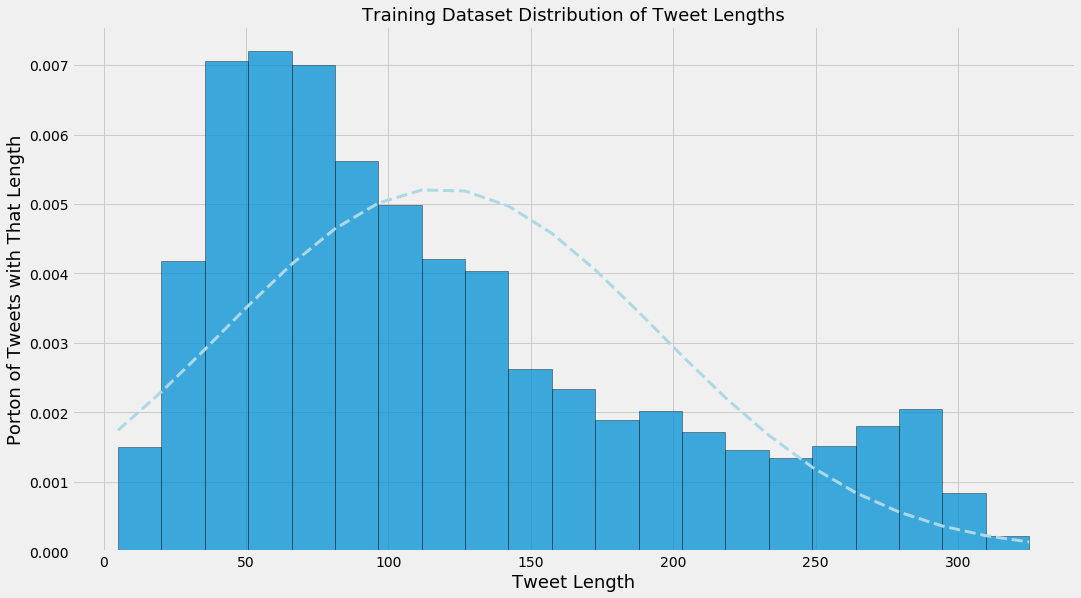

In [87]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
ax.plot(bins, length_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Porton of Tweets with That Length", fontsize=18);

plt.show()

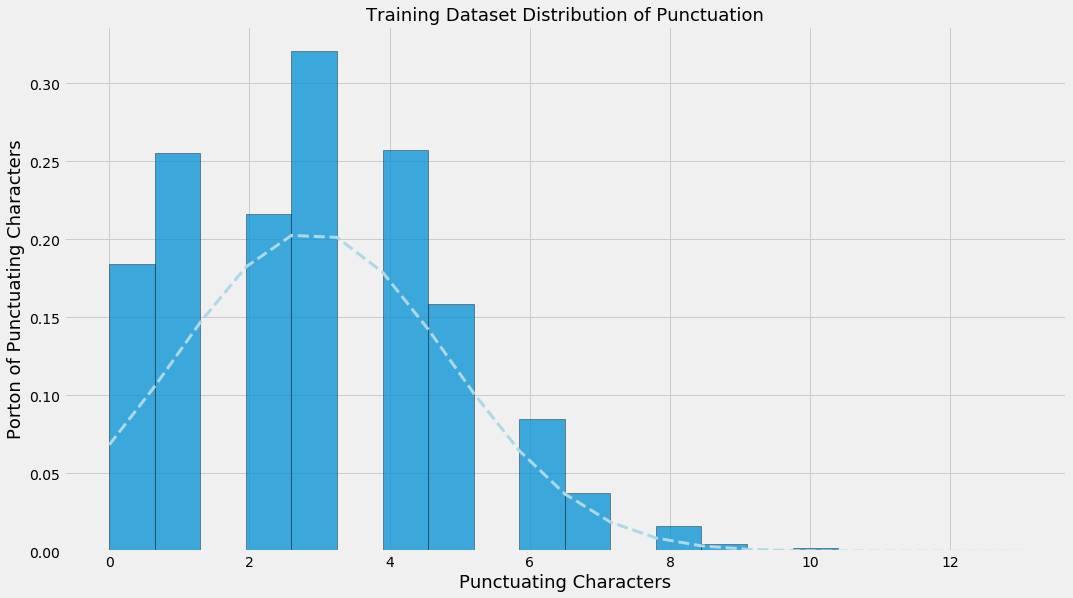

In [88]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
ax.plot(bins, punctution_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters", fontsize=18)
ax.set_ylabel("Porton of Punctuating Characters", fontsize=18)

plt.show()

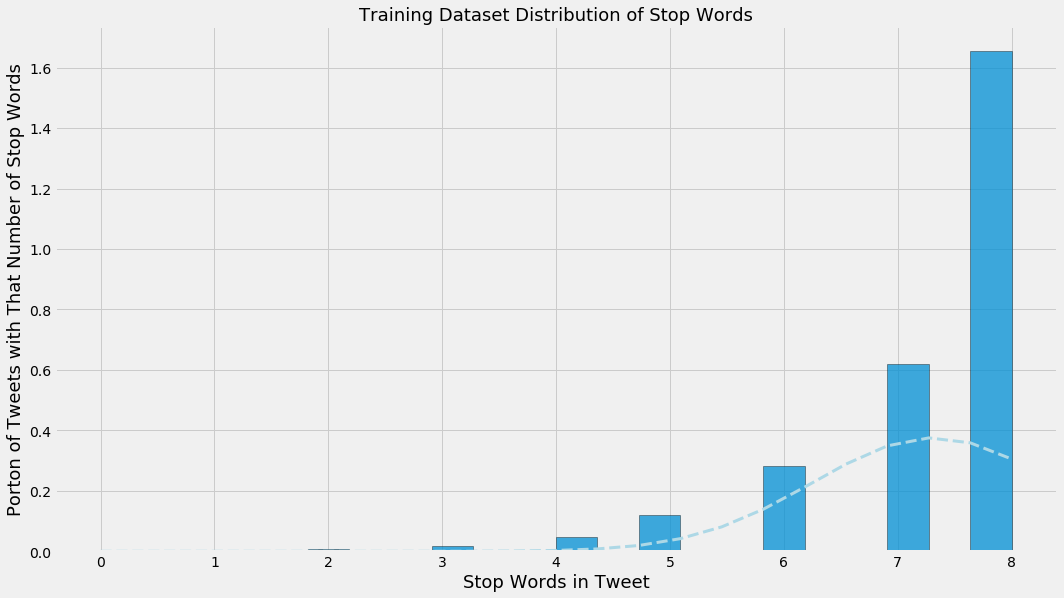

In [89]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
ax.plot(bins, stop_words_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

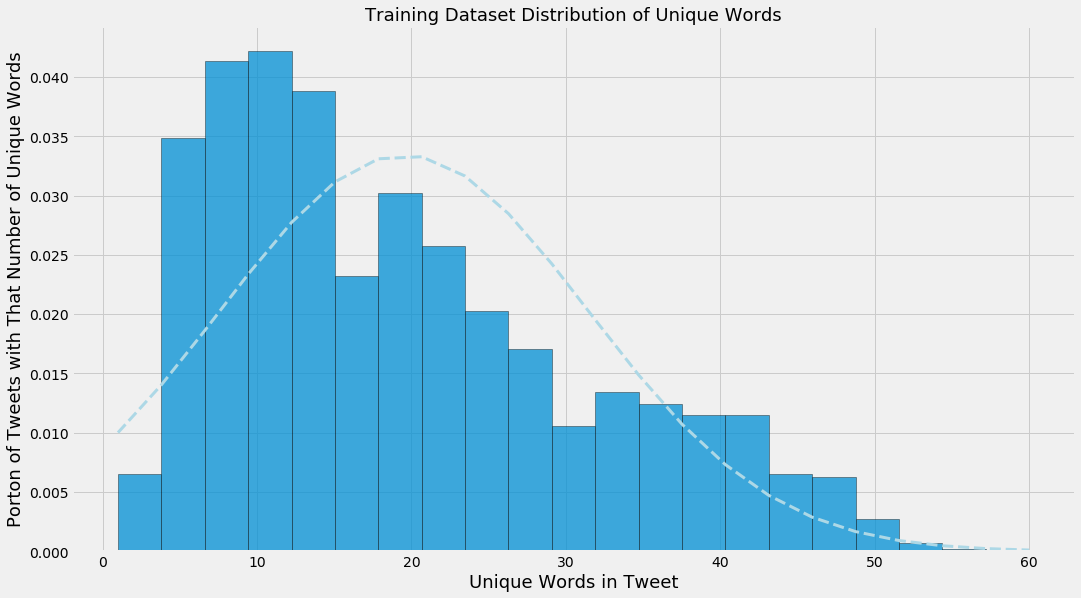

In [90]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, bins="doane", edgecolor="black", density=True, alpha=0.75)

unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
ax.plot(bins, unique_words_line, "--", linewidth=3, color="lightblue")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Porton of Tweets with That Number of Unique Words", fontsize=18)

plt.show()